In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTImageProcessor
from tqdm import tqdm

2025-09-22 16:20:23.060253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758558023.254999      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758558023.314959      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 1. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# 2. Image Preprocessing
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

In [5]:
# 3. Load Dataset from Folders
train_dataset = datasets.ImageFolder("/kaggle/input/skin-cancer-images/Train/Train", transform=train_transforms)
test_dataset = datasets.ImageFolder("/kaggle/input/skin-cancer-images/Val/Val", transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
num_classes = len(train_dataset.classes)  # should be 2
num_classes

2

In [7]:
from transformers import ViTForImageClassification

# Load with default head
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

# Replace classifier
model.classifier = nn.Linear(model.classifier.in_features, 2)

model.to(device)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [8]:
# 5. Optimizer & Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

In [9]:
# 6. Training Loop with tqdm
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    print(f"\nEpoch {epoch+1}/{epochs}")
    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        outputs = model(pixel_values=images).logits
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Acc": f"{100 * correct / total:.2f}%"
        })

    avg_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}%")


Epoch 1/5


Epoch [1/5] | Loss: 0.3296 | Train Acc: 85.25%

Epoch 2/5


Epoch [2/5] | Loss: 0.2224 | Train Acc: 90.74%

Epoch 3/5


Epoch [3/5] | Loss: 0.1535 | Train Acc: 93.85%

Epoch 4/5


Epoch [4/5] | Loss: 0.1020 | Train Acc: 96.03%

Epoch 5/5


Epoch [5/5] | Loss: 0.0725 | Train Acc: 97.32%


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

In [11]:
model.eval()
all_preds, all_labels = [], []
total_loss = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(pixel_values=images).logits
        loss = criterion(outputs, labels)  # compute loss
        total_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Evaluating: 100%|██████████| 221/221 [06:28<00:00,  1.76s/it]


In [12]:
# Average test loss
avg_test_loss = total_loss / len(test_loader)

In [13]:
# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [14]:
# ---- Metrics ----
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average="binary")   # since cancerous/non-cancerous (binary)
rec = recall_score(all_labels, all_preds, average="binary")
f1 = f1_score(all_labels, all_preds, average="binary")
cm = confusion_matrix(all_labels, all_preds)

print("\n📊 Final Evaluation Metrics:")
print(f"Test Loss      : {avg_test_loss:.4f}")
print(f"Accuracy       : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1 Score       : {f1:.4f}")
print("\nConfusion Matrix:")
print(cm)


📊 Final Evaluation Metrics:
Test Loss      : 0.2173
Accuracy       : 0.9291
Precision      : 0.9408
Recall         : 0.9335
F1 Score       : 0.9371

Confusion Matrix:
[[5661  470]
 [ 532 7469]]


<Axes: >

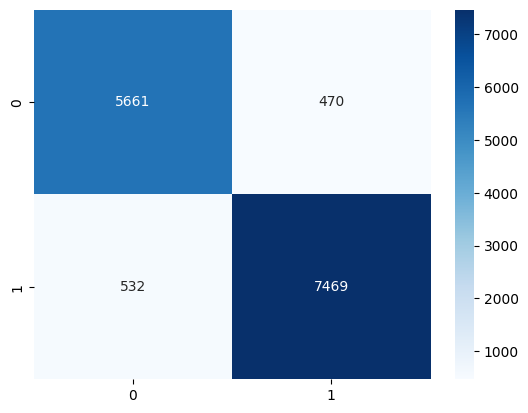

In [20]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [15]:
# 7. Save Model
torch.save(model.state_dict(), "skin_cancer_vit.pth")